In [1]:
#import de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Paso 3: Identificación del tipo de variables

# Cargar dataset
df = pd.read_csv("../datos_simulados/datos_final.csv")

# Convertir 'Indice_contraccion_%' en categórica ordinal
#df['Indice_contraccion_%'] = df['Indice_contraccion_%'].astype(str)

# Clasificación de variables
variables_categoricas = [
    'Clase', 'Pieza', 'Superficie_1', 'Superficie_2',
    'Estado_cavidad', 'Tecnica', 'Tipo_resina', 'Ajuste_margen',
    'Indice_contraccion_%',
]

variables_numericas = [
    'Tamanio_cavidad_mm', 'Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Margen_cavo_mm'
]

# Mostrar resumen
print("Variables categóricas:", variables_categoricas)
print("Variables numéricas:", variables_numericas)

# Vista previa
df.head()


Variables categóricas: ['Clase', 'Pieza', 'Superficie_1', 'Superficie_2', 'Estado_cavidad', 'Tecnica', 'Tipo_resina', 'Ajuste_margen', 'Indice_contraccion_%']
Variables numéricas: ['Tamanio_cavidad_mm', 'Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Margen_cavo_mm']


,Clase,Pieza,Superficie_1,Superficie_2,Tamanio_cavidad_mm,Estado_cavidad,Tecnica,Tipo_resina,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Ajuste_margen
0,V,32,Bucal,ninguna,3.69,limpia,Bulk,Compuesta,2.0,81.56,8.15,3.64,Equiobturado
1,II,32,Distal,ninguna,2.51,con_tejido,Bulk,Con fibra de vidrio,1.0,143.93,18.62,2.08,Subobturado
2,III,8,Mesial,ninguna,4.11,limpia,Estratificacion,Compuesta,2.0,71.58,9.67,3.98,Equiobturado
3,I,1,Bucal,ninguna,1.04,con_tejido,Estratificacion,Con fibra de vidrio,1.0,110.02,9.04,1.23,Sobreobturado
4,V,25,Lingual,ninguna,1.31,con_tejido,Bulk,Con fibra de vidrio,1.0,118.06,5.29,0.77,Subobturado


In [3]:
# Paso 4a: Estadística descriptiva y distribución de variables

# Estadística descriptiva para variables numéricas
df.describe()

,Pieza,Tamanio_cavidad_mm,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm
count,18600.000000,18600.000000,18600.000000,18600.000000,18600.000000,18600.000000
mean,16.500000,3.245473,2.002016,96.427615,9.663341,3.244862
std,9.136755,1.218807,0.938772,21.495510,6.098695,1.310104
min,1.000000,1.000000,1.000000,50.010000,0.000000,0.110000
25%,8.750000,2.250000,1.000000,79.160000,4.600000,2.240000
50%,16.500000,3.260000,1.500000,96.680000,9.200000,3.270000
75%,24.250000,4.220000,3.500000,111.850000,13.960000,4.240000
max,32.000000,6.000000,3.500000,149.980000,29.650000,6.900000


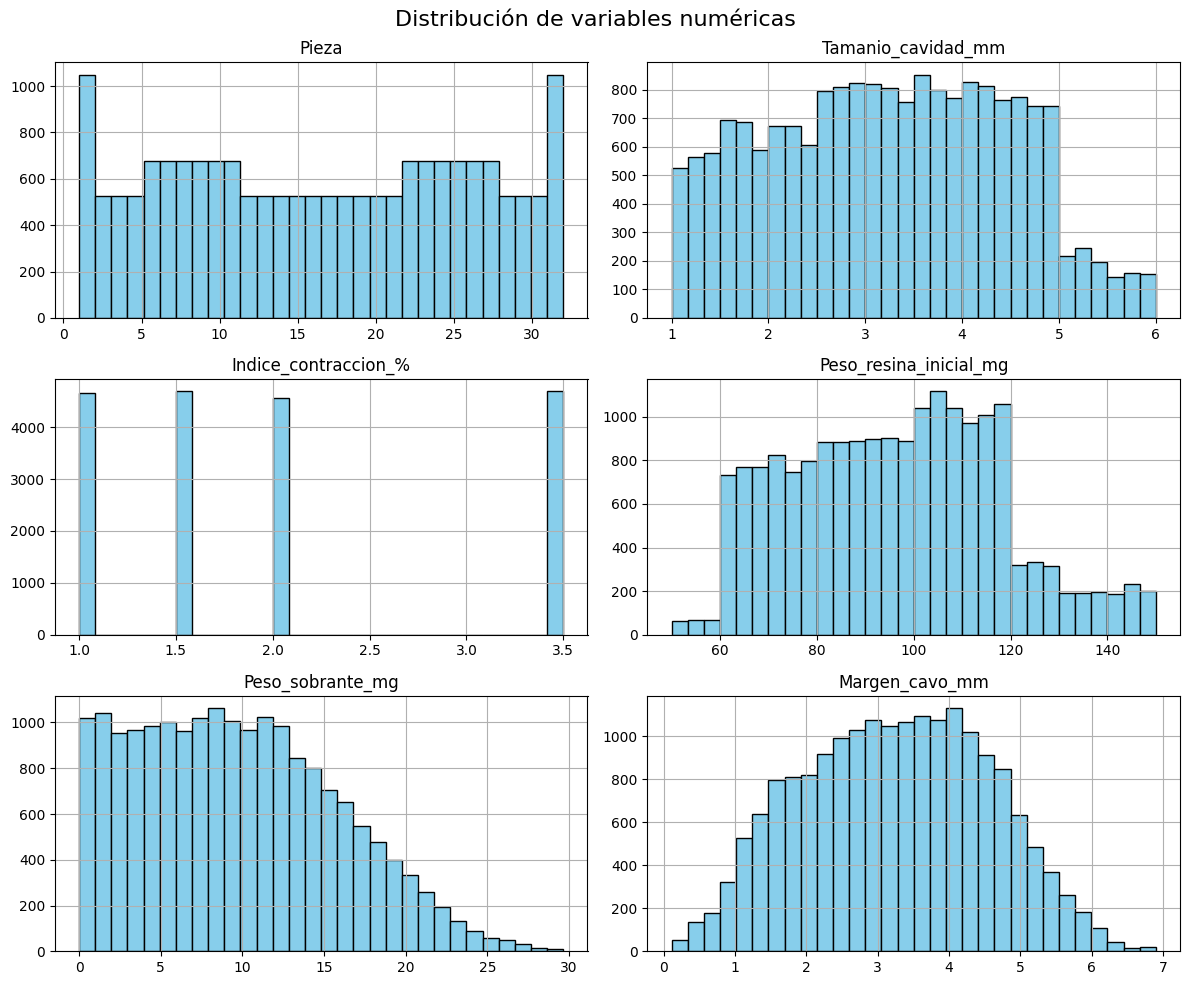

In [4]:
df.hist(
    figsize=(12, 10),
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()


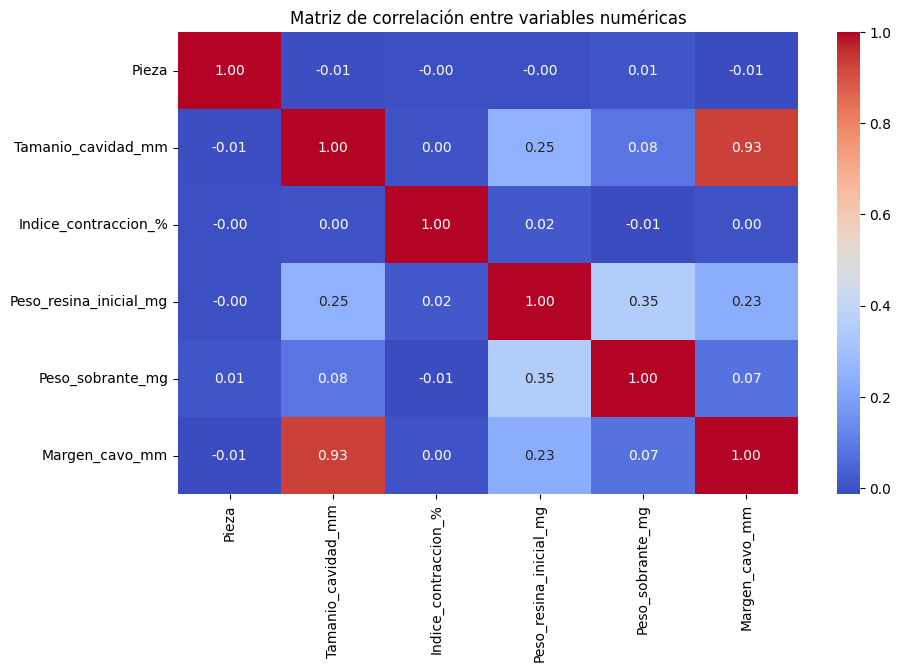

In [5]:
# Paso 4b: Correlación de variables numéricas

# Mapa de calor de correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


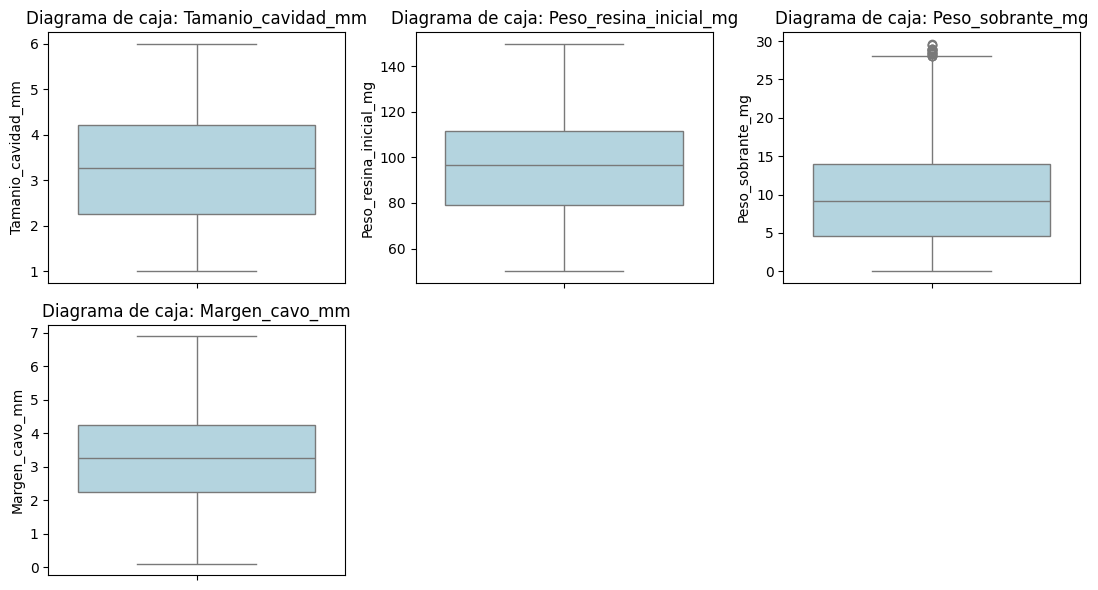

In [6]:
# Paso 4c: Diagramas de caja para detectar outliers

plt.figure(figsize=(11, 6))
for i, col in enumerate(variables_numericas):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Diagrama de caja: {col}')
    plt.tight_layout()
plt.show()


In [7]:
# Paso 5c: Verificación y eliminación de duplicados exactos

# Contar duplicados
duplicados = df.duplicated().sum()
print(f"Filas duplicadas exactas: {duplicados}")

# Eliminar si existen
if duplicados > 0:
    df = df.drop_duplicates()


Filas duplicadas exactas: 0


In [8]:
# Paso 5b: Tratamiento de outliers

# Solo se tratarán los outliers en 'Peso_sobrante_mg'
# porque fue la única variable que presentó valores atípicos evidentes en los diagramas de caja.
# Las demás variables muestran distribuciones esperadas o sin puntos extremos significativos.

# Calcular límites para detección de outliers (IQR)
q1 = df['Peso_sobrante_mg'].quantile(0.25)
q3 = df['Peso_sobrante_mg'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Contar antes de filtrar
filas_antes = df.shape[0]

# Filtrar outliers
df = df[(df['Peso_sobrante_mg'] >= limite_inferior) & (df['Peso_sobrante_mg'] <= limite_superior)]

# Contar después de filtrar
filas_despues = df.shape[0]
print(f"Filas eliminadas por outliers en 'Peso_sobrante_mg': {filas_antes - filas_despues}")


Filas eliminadas por outliers en 'Peso_sobrante_mg': 17


In [9]:
# Paso 6a: Validar que no existan datos nulos

valores_nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(valores_nulos)

print("\nTotal de celdas con valores nulos:", valores_nulos.sum())


Valores nulos por columna:
Clase                     0
Pieza                     0
Superficie_1              0
Superficie_2              0
Tamanio_cavidad_mm        0
Estado_cavidad            0
Tecnica                   0
Tipo_resina               0
Indice_contraccion_%      0
Peso_resina_inicial_mg    0
Peso_sobrante_mg          0
Margen_cavo_mm            0
Ajuste_margen             0
dtype: int64

Total de celdas con valores nulos: 0


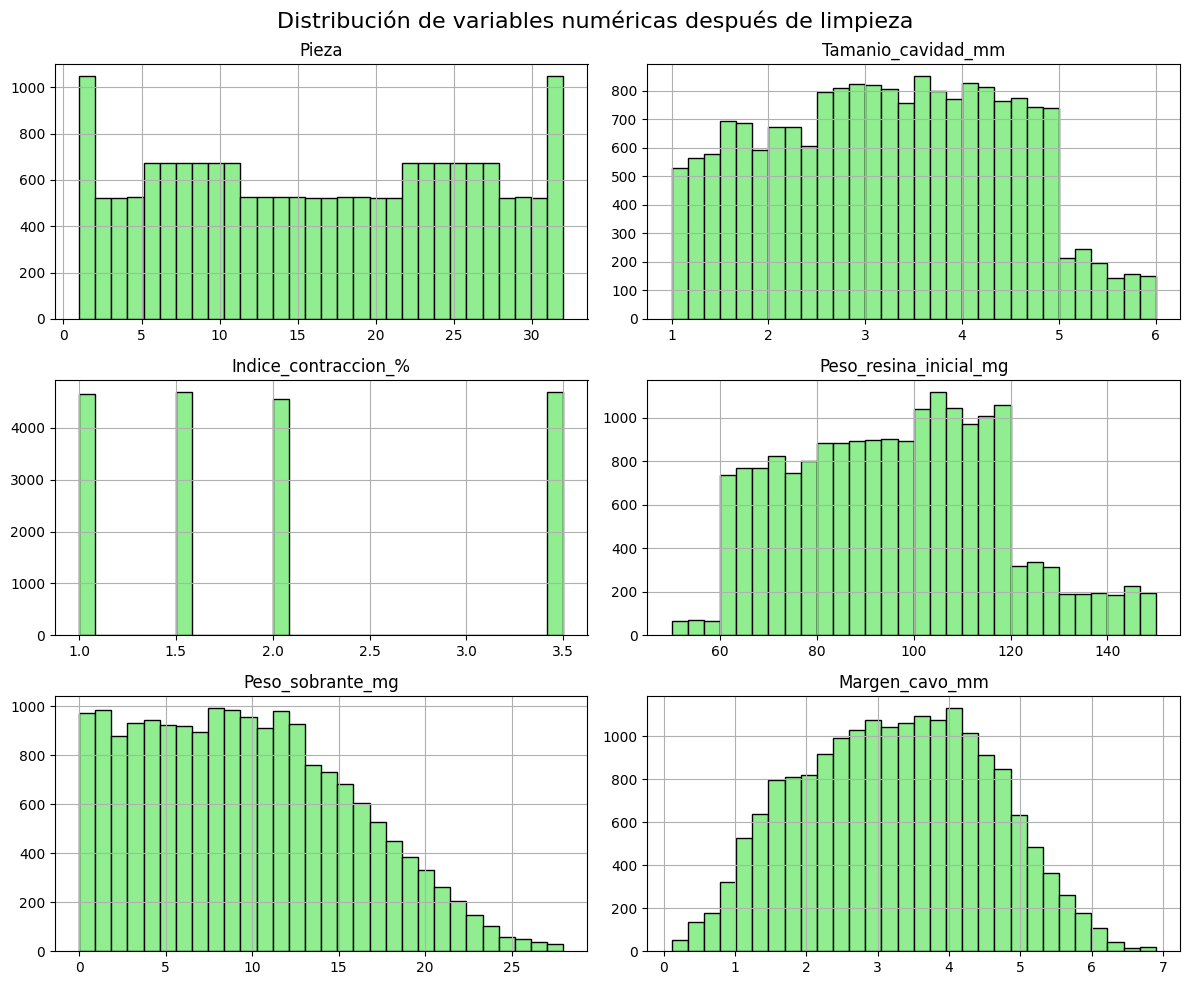

In [10]:
# Paso 6b: Verificar efecto de las transformaciones aplicadas

# Histograma actualizado para ver si hay cambios en las distribuciones
df.hist(
    figsize=(12, 10),
    bins=30,
    color='lightgreen',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas después de limpieza", fontsize=16)
plt.tight_layout()
plt.show()


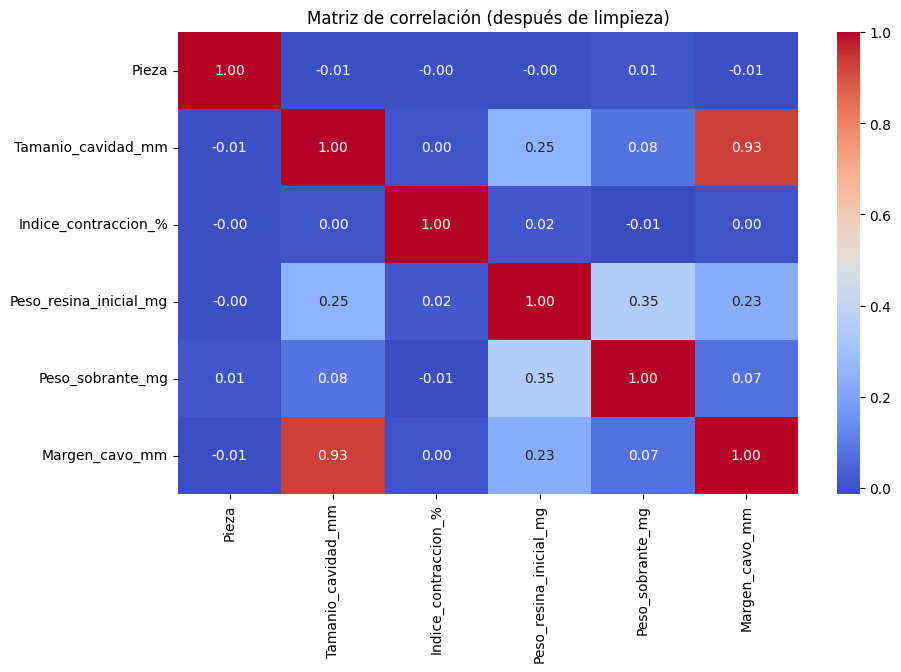

In [11]:
# Paso 6c: Identificar si surgieron nuevos patrones o problemas

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación (después de limpieza)")
plt.show()


In [12]:
# Paso 6e: Cálculo de diferencias en correlaciones (pre/post tratamiento)

# (1) Releer el dataset original sin transformaciones
df_original = pd.read_csv("../datos_simulados/datos_final.csv")

# (2) Calcular matriz de correlación original
corr_original = df_original.corr(numeric_only=True)

# (3) Calcular matriz de correlación actual (después del tratamiento)
corr_actual = df.corr(numeric_only=True)

# (4) Comparar ambas
diferencia = (corr_actual - corr_original).abs()

print("Diferencia absoluta entre correlaciones pre/post tratamiento:")
print(diferencia)


Diferencia absoluta entre correlaciones pre/post tratamiento:
                           Pieza  Tamanio_cavidad_mm  Indice_contraccion_%  \
Pieza                   0.000000            0.000524              0.000164   
Tamanio_cavidad_mm      0.000524            0.000000              0.000188   
Indice_contraccion_%    0.000164            0.000188              0.000000   
Peso_resina_inicial_mg  0.000396            0.001754              0.000359   
Peso_sobrante_mg        0.000524            0.003007              0.000316   
Margen_cavo_mm          0.000488            0.000053              0.000264   

                        Peso_resina_inicial_mg  Peso_sobrante_mg  \
Pieza                                 0.000396          0.000524   
Tamanio_cavidad_mm                    0.001754          0.003007   
Indice_contraccion_%                  0.000359          0.000316   
Peso_resina_inicial_mg                0.000000          0.004220   
Peso_sobrante_mg                      0.004220     

In [13]:
# Paso 7: Entrenamiento del modelo de regresión lineal

# Variables predictoras y variable objetivo
X = df.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg'])  # quitamos también la sobrante
y = df['Peso_resina_inicial_mg']

# Codificar variables categóricas (One-Hot)
X = pd.get_dummies(X, drop_first=True)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo
modelo = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=3,
    random_state=42
)
modelo.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modelo.predict(X_test_scaled)

# Métricas
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.2f}")

RMSE: 16.69
MAE : 14.42
R²  : 0.39


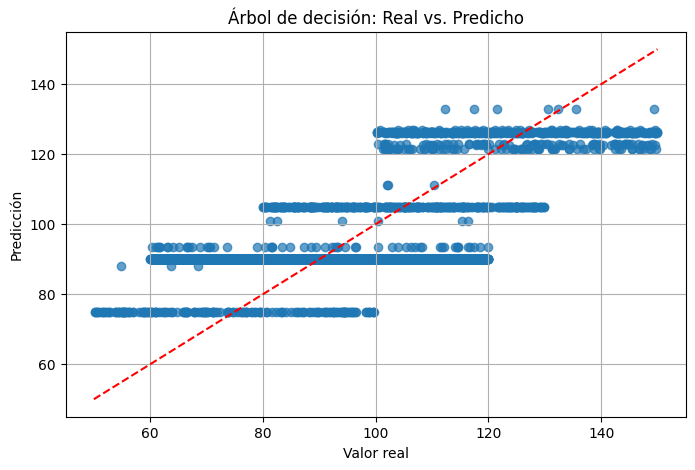

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Árbol de decisión: Real vs. Predicho")
plt.grid(True)
plt.show()